# Here I explore the prophet forecasting library.



In [10]:
# All my imports
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

print("Done")


Done


In [6]:
!pip install sklearn


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=7d22d0e43761d9f8b2ee7f6fa2a0b8e682901dd23d7b3658c986d594c773d8ac
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\c5\88\35\cc8a1e198b27a1d3d9d3f9b30090b9d5531778847835472ec4
Successfully built sklearn


In [14]:
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

# introduce our data
raw_data = pd.read_csv("BTC.csv",index_col=[0], parse_dates=[0])


# my interest is in the close price, so I'll choose that
data = raw_data.iloc[:,[3]]

print(data)

               close
Date                
2020-03-01   8531.88
2020-03-02   8915.24
2020-03-03   8760.07
2020-03-04   8750.87
2020-03-05   9054.68
...              ...
2022-11-21  15781.29
2022-11-22  16226.94
2022-11-23  16603.11
2022-11-24  16598.95
2022-11-25  16532.42

[1000 rows x 1 columns]


## plot it to get a general overview

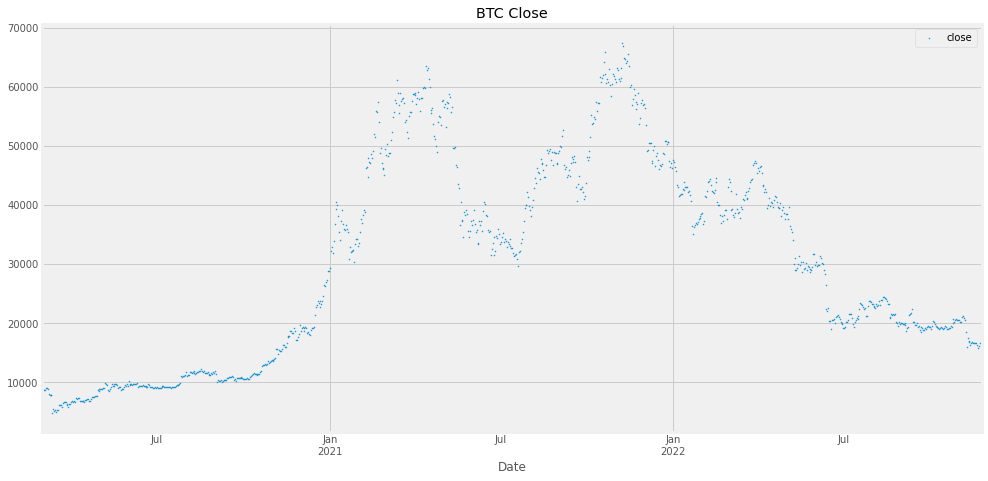

In [17]:
color_pal = sns.color_palette()  # make a color palette
data.plot(style='.', figsize=(15, 7.5), ms=1, color=color_pal[0],
          title="BTC Close")
plt.show()


## Create some Time Series Features to visualize our data and better understand it


In [18]:

category_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday',
                                             'Thurday', 'Friday', 'Saturday',
                                             'Sunday'],
                                 ordered=True)


def create_features(data, label=None):
    data_copy = data.copy()
    data_copy['Date'] = data_copy.index
    data_copy['DayOfWeek'] = data_copy['Date'].dt.dayofweek
    data_copy['Weekday'] = data_copy['Date'].dt.day_name()
    data_copy['Weekday'] = data_copy['Weekday'].astype(category_type)
    data_copy['Quarter'] = data_copy['Date'].dt.quarter
    data_copy['Month'] = data_copy['Date'].dt.month
    data_copy['Year'] = data_copy['Date'].dt.year
    data_copy['DayOfYear'] = data_copy['Date'].dt.dayofyear
    data_copy['WeekOfYear'] = data_copy['Date'].dt.isocalendar().week
    data_copy['Date_Offset'] = (data_copy.Date.dt.month*100 + data_copy.Date.dt.day-320) % 1300

    data_copy['Season'] = (data_copy.Date.dt.month*100 + data_copy.Date.dt.day - 320) % 1300

    data_copy['Season'] = pd.cut(data_copy['Date_Offset'], [0, 300, 602, 900, 1300],
                                 labels=['Spring', 'Summer', 'Fall', 'Winter'])

    X = data_copy[['DayOfWeek', 'Quarter', 'Month', 'Year', 'DayOfYear', 'WeekOfYear', 'Weekday', 'Season']]

    if label:
        y = data_copy[label]
        return X, y
    return X


X, y = create_features(data, label='close')

features_n_target = pd.concat([X, y], axis=1)
print(features_n_target)


            DayOfWeek  Quarter  Month  Year  DayOfYear  WeekOfYear    Weekday  \
Date                                                                            
2020-03-01          6        1      3  2020         61           9     Sunday   
2020-03-02          0        1      3  2020         62          10     Monday   
2020-03-03          1        1      3  2020         63          10    Tuesday   
2020-03-04          2        1      3  2020         64          10  Wednesday   
2020-03-05          3        1      3  2020         65          10        NaN   
...               ...      ...    ...   ...        ...         ...        ...   
2022-11-21          0        4     11  2022        325          47     Monday   
2022-11-22          1        4     11  2022        326          47    Tuesday   
2022-11-23          2        4     11  2022        327          47  Wednesday   
2022-11-24          3        4     11  2022        328          47        NaN   
2022-11-25          4       

## Plotting our features

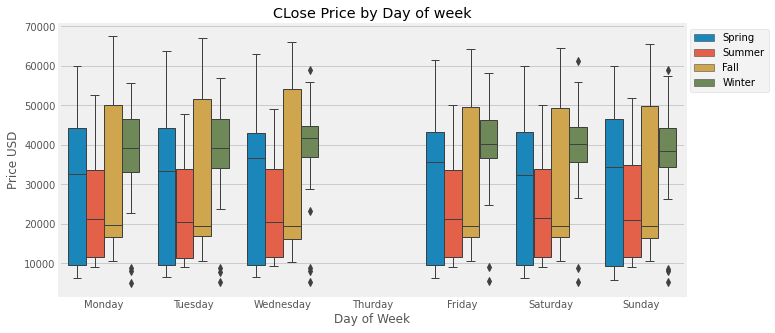

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_n_target.dropna(),
            x='Weekday',
            y='close',
            hue='Season',
            ax=ax,
            linewidth=1)
ax.set_title('CLose Price by Day of week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Price USD')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()


## Train / test split

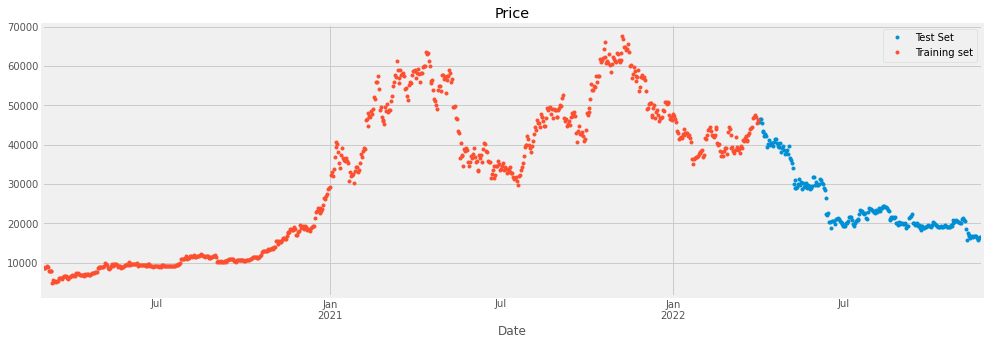

In [20]:
split_date = '2022-04-01'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

# visualize the split and rename some columns
data_test \
    .rename(columns={'close':'Test Set'}) \
    .join(data_train.rename(columns={'close':'Training set'}),
          how='outer') \
    .plot(figsize=(15, 5), title='Price', style='.')
plt.show()

In [21]:

# Going into the prophet model. timestamp column renamed to ds, close renamed to y

data_train_prophet = data_train.reset_index() \
    .rename(columns= {"Date" : "ds",
                      'close':'y'})

# Predicting the future
model = Prophet()
model.fit(data_train_prophet)

data_test_prophet = data_test.reset_index() \
    .rename(columns={'Date':"ds",
                     'close':'y'})
data_test_fcst = model.predict(data_test_prophet)
print(data_test_fcst.to_string())

05:48:25 - cmdstanpy - INFO - Chain [1] start processing
05:48:26 - cmdstanpy - INFO - Chain [1] done processing


            ds         trend    yhat_lower    yhat_upper   trend_lower   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper      weekly  weekly_lower  weekly_upper        yearly  yearly_lower  yearly_upper  multiplicative_terms  multiplicative_terms_lower  multiplicative_terms_upper          yhat
0   2022-04-02  21106.409591  32814.977981  40346.193058  21106.409591  21106.409591    15337.277541          15337.277541          15337.277541  -82.430361    -82.430361    -82.430361  15419.707902  15419.707902  15419.707902                   0.0                         0.0                         0.0  36443.687133
1   2022-04-03  20841.380967  32042.981696  39581.785471  20841.380967  20841.380967    15058.872156          15058.872156          15058.872156  -39.159983    -39.159983    -39.159983  15098.032140  15098.032140  15098.032140                   0.0                         0.0                         0.0  35900.253123
2   2022-04-04  20576.352342  31526.861896 

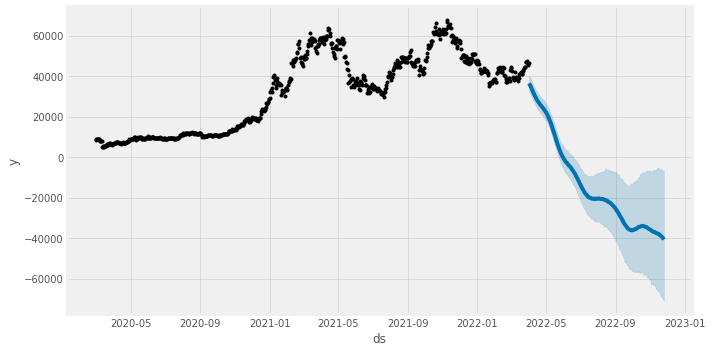

In [22]:
# printing out the prediction
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(data_test_fcst, ax=ax)
#plt.show()


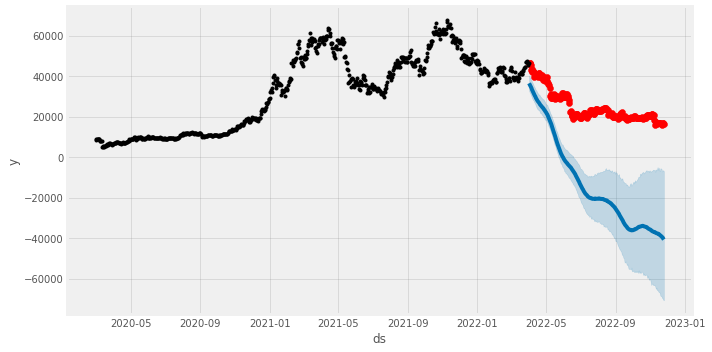

In [23]:
# comparing prediction to real data
f, ax = plt.subplots(figsize=(10, 5))
ax.scatter(data_test.index, data_test['close'], color='r')
fig = model.plot(data_test_fcst, ax=ax)
plt.show()

In [ ]:
# TODO: IMPROVE FORECASTING